*Last Modified*: March 3rd, 2023. [OI]

## CHAMP (CHallenging Minisatellite Payload) thermospheric neutral density data derived via STAR (Space Three-axis Accelerometer for Research) accelerometer data. 
Downloaded from http://thermosphere.tudelft.nl/

##### References
[1] Masutti, D., March, G., Ridley, A. J., and Thoemel, J., “Effect of the solar activity variation on the Global Ionosphere Thermosphere Model (GITM)”, *Annales Geophysicae*, vol. 34, no. 9, pp. 725–736, 2016. doi:10.5194/angeo-34-725-2016.

##### Time period
The specific simulation windows have been selected in periods of low geomagnetic activity ($A_{p}$ < 30) in order to avoid any geomagnetic storm that could interfere with the study.

* Solar *Maximum* Cycle 23: 18/12/2001 $\to$ F10.7 $\approx 233$

* Solar *Minimum* Cycle 23: 24/10/2008 $\to$ F10.7 $\approx 66$

In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import numpy as np
from pandas import read_csv
import pandas as pd
import datetime as df
import astropy
from pymsis import msis
from astropy.coordinates import SkyCoord
from datetime import datetime, timedelta
from astropy.constants import R_earth
import astropy.units as u
from astropy import time

In [3]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 11}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=11) 
matplotlib.rc('ytick', labelsize=11) 

In [4]:
data = read_csv("data_champ/CH_DNS_ACC_2008_10_v02.txt", sep='\s+', on_bad_lines='skip')
data

,date,time,GPS/UTC,alt,lon,lat,lst,arglat,rho_x,rho_mean,Colu,Colu.1
0,2008-10-01,00:00:00.000,GPS,326044.167,49.144013,10.553110,3.444,10.472099,1.662481e-12,1.868571e-12,0.0,0.0
1,2008-10-01,00:00:10.000,GPS,326016.699,49.135305,11.215545,3.446,11.131414,1.665051e-12,1.868629e-12,0.0,0.0
2,2008-10-01,00:00:20.000,GPS,325993.920,49.126748,11.877959,3.448,11.790748,1.669296e-12,1.868687e-12,0.0,0.0
3,2008-10-01,00:00:30.000,GPS,325975.799,49.118352,12.540349,3.451,12.450101,1.678171e-12,1.868745e-12,0.0,0.0
4,2008-10-01,00:00:40.000,GPS,325962.304,49.110127,13.202712,3.453,13.109473,1.706243e-12,1.868803e-12,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
262856,2008-10-31,23:59:10.000,GPS,333479.106,170.030833,79.928660,11.591,99.715948,2.400383e-12,2.682148e-12,0.0,0.0
262857,2008-10-31,23:59:20.000,GPS,333425.800,170.960426,79.295574,11.655,100.376738,2.390056e-12,2.682253e-12,0.0,0.0
262858,2008-10-31,23:59:30.000,GPS,333369.270,171.782553,78.659785,11.713,101.037525,2.336933e-12,2.682357e-12,0.0,0.0
262859,2008-10-31,23:59:40.000,GPS,333309.556,172.513970,78.021714,11.765,101.698311,2.315419e-12,2.682461e-12,0.0,0.0


In [5]:
data_timestamps = []

In [6]:
# save all timestamps in UTC. 
for ii in range(np.shape(data)[0]):
    # timestamp in GPS from chart. 
    GPS_timestamp = time.Time(str(data["date"][ii] + "T" + data["time"][ii])).gps
    GPS_time = time.Time(GPS_timestamp, format="gps")
    # convert to UTC [which is approx 12 seconds ahead].
    UTC_time = time.Time(GPS_time, format='iso',  scale='utc').value
    # add UTC timestamp to a list
    data_timestamps.append(pd.Timestamp(year=int(UTC_time[:4]), 
                                    month=int(UTC_time[5:7]), 
                                    day=int(UTC_time[8:10]),
                                    hour=int(UTC_time[11:13]), 
                                    minute=int(UTC_time[14:16]), 
                                    second=int(UTC_time[17:19]), 
                                    microsecond=int(UTC_time[20:])))

In [7]:
# coordinate transformation from geodetic to geocenteric
coords_geodetic = astropy.coordinates.EarthLocation.from_geodetic(lon=data["lon"]*u.deg, 
                                                         lat=data["lat"]*u.deg, 
                                                         height=data["alt"]*u.m, 
                                                         ellipsoid="GRS80")

x, y, z = coords_geodetic.geocentric

In [8]:
# descibe in spherical coordinates
coords_geocentric = astropy.coordinates.cartesian_to_spherical(x=x, y=y,z=z)
coords_geocentric

(<Distance [6703469.43674745, 6703350.96292721, 6703231.92965602, ...,
            6690954.85825366, 6690990.11211103, 6691027.40701409] m>,
 <Latitude [0.18303957, 0.1945328 , 0.20602632, ..., 1.37163795, 1.36043607,
            1.34920076] rad>,
 <Longitude [0.85772483, 0.85757285, 0.8574235 , ..., 2.99817114,
             3.01093678, 3.02235498] rad>)

### Considered time period 3 days of "spin off" and 1 day of simulation

In [9]:
max_timestamp = 205000
min_timestamp = 168000

In [10]:
print(data_timestamps[min_timestamp])
print(data_timestamps[max_timestamp])

2008-10-21 00:29:50
2008-10-25 07:16:30


### Intersection with San Diego

In [29]:
san_diego_lon, san_diego_lat = -117.1611, 32.7157

In [30]:
index_lon = np.where(np.abs(coords_geocentric[2].to(u.deg)[min_timestamp:max_timestamp]-180*u.deg - san_diego_lon*u.deg) < 3*u.deg)

In [31]:
index_lat = np.where(np.abs(coords_geocentric[1].to(u.deg)[min_timestamp:max_timestamp] - san_diego_lat*u.deg) < 2*u.deg)

In [32]:
index_intersect = np.intersect1d(index_lon, index_lat)

### Plot CHAMP meassurements

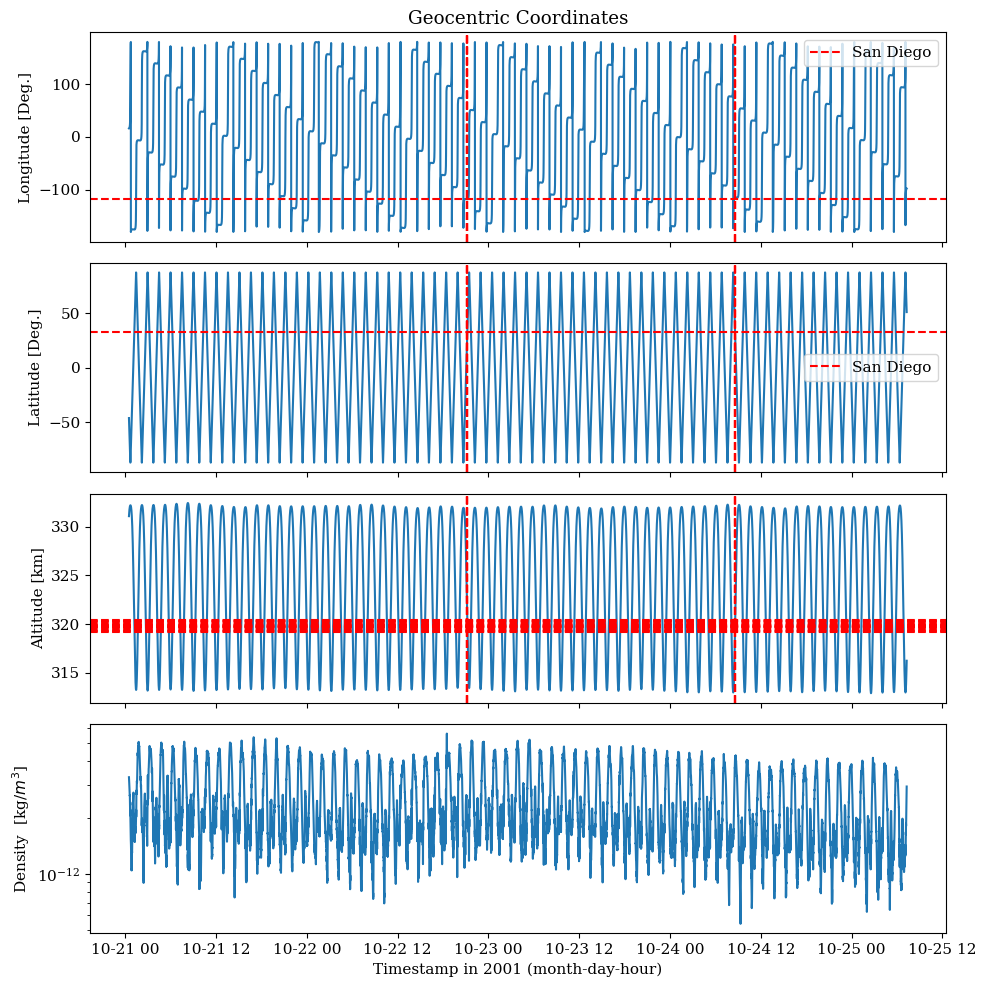

In [34]:
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(10, 10))
ax[0].plot(data_timestamps[min_timestamp :max_timestamp], coords_geocentric[2].to(u.deg)[min_timestamp :max_timestamp]-180*u.deg)
ax[0].axhline(san_diego_lon, c="r", ls="--", label="San Diego")
ax[0].set_ylabel("Longitude [Deg.]")
ax[1].plot(data_timestamps[min_timestamp :max_timestamp], coords_geocentric[1].to(u.deg)[min_timestamp :max_timestamp])
ax[1].set_ylabel("Latitude [Deg.]")
ax[1].axhline(san_diego_lat, c="r", ls="--", label="San Diego")
ax[2].plot(data_timestamps[min_timestamp :max_timestamp], (coords_geocentric[0] - R_earth).to(u.km)[min_timestamp :max_timestamp])
ax[2].set_ylabel("Altitude [km]")
ax[3].plot(data_timestamps[min_timestamp :max_timestamp], data["rho_x"][min_timestamp :max_timestamp])
ax[3].set_ylabel(r"Density  [kg/$m^3$]")
ax[0].set_title("Geocentric Coordinates")
ax[3].set_xlabel("Timestamp in 2001 (month-day-hour)")

for ii in index_intersect:
    ax[0].axvline(data_timestamps[min_timestamp + ii],c="r", ls="--")
    ax[1].axvline(data_timestamps[min_timestamp + ii],c="r", ls="--")
    ax[2].axvline(data_timestamps[min_timestamp + ii],c="r", ls="--")
    ax[2].axhline((coords_geocentric[0].to(u.m) - R_earth).to(u.km).value[min_timestamp + ii], c="r", ls="--")
    
_ = ax[0].legend()
_ = ax[1].legend()
_ = ax[3].set_yscale("log")
plt.tight_layout()
plt.savefig("figs/CHAMP_location_and_observations_2008.png", dpi=600)

## Read in F10.7

In [16]:
f10p7_msis, f10p7a_msis, ap_msis = msis.get_f107_ap(dates=data_timestamps[min_timestamp:max_timestamp])

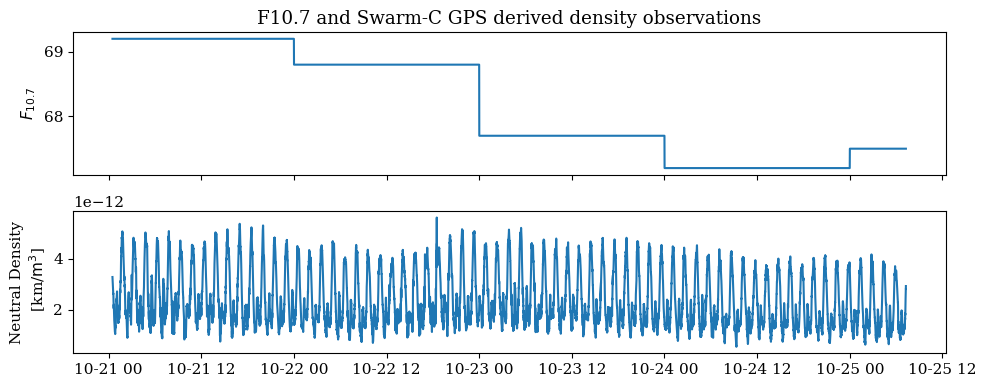

In [17]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10, 4))
ax[0].plot(data_timestamps[min_timestamp:max_timestamp], f10p7_msis, label="F10.7")
ax[1].plot(data_timestamps[min_timestamp:max_timestamp], data["rho_x"][min_timestamp:max_timestamp])
#ax[1].set_yscale("log")
ax[0].set_ylabel("$F_{10.7}$")
ax[0].set_title("F10.7 and Swarm-C GPS derived density observations")
#ax[0].legend()
_ = ax[1].set_ylabel("Neutral Density\n [km/$\mathrm{m}^3$]")
plt.tight_layout()
plt.savefig("figs/swarm_meassurements_and_f10.7_2008.png", dpi=600)

## Read in 1D-GITM Results

In [18]:
cdir = os.getcwd()

In [19]:
fidelity = "f4"

In [20]:
parameters = np.load(cdir[:-10] + "solutions_CHAMP_2008/" + str(fidelity) + "/parameters.npy", allow_pickle=True).item()
pde = np.load(cdir[:-10] + "solutions_CHAMP_2008/" + str(fidelity) + "/pde.npy", allow_pickle=True).item()
mesh = np.load(cdir[:-10] + "solutions_CHAMP_2008/" + str(fidelity) + "/mesh.npy", allow_pickle=True).item()
dmd = np.load(cdir[:-10] + "solutions_CHAMP_2008/" + str(fidelity) + "/dmd.npy", allow_pickle=True)
master = np.load(cdir[:-10] + "solutions_CHAMP_2008/" + str(fidelity) + "/master.npy", allow_pickle=True).item()
sol = np.load(cdir[:-10] + "solutions_CHAMP_2008/" + str(fidelity) + "/sol.npy", allow_pickle=True)

In [21]:
n_components, n_solution, n_resolution, n_timestamp = np.shape(sol)
print(np.shape(sol))

(3, 6, 15, 191)


In [22]:
# get parameters
rho0 = pde["physicsparam"][19]
H0 = pde["physicsparam"][17]
T0 = pde["physicsparam"][18]

In [23]:
computational_grid = mesh["dgnodes"].flatten("F")
phys_grid = ((computational_grid * float(H0) - R_earth.value) * u.m).to(u.km)

In [24]:
rho = np.exp(sol[:, 0, :, :]).flatten("F")
vr = sol[:, 1, :, :].flatten("F") / np.sqrt(rho)
T = sol[:, 2, :, :].flatten("F") / np.sqrt(rho)

In [25]:
time_stamp_gitm = []
for ii in range(n_timestamp):
    time_stamp_gitm.append(datetime.strptime(parameters["date"], '%Y-%m-%d %H:%M:%S') + timedelta(minutes=30)*ii)

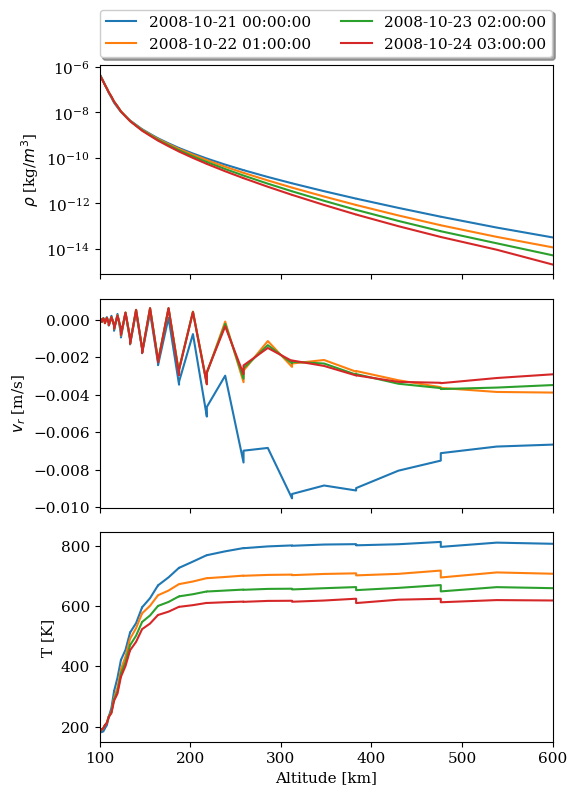

In [26]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(6, 8))

for ii in np.arange(0, n_timestamp, 50):
    # solution
    rho = np.exp(sol[:, 0, :, ii]).flatten("F")
    vr = sol[:, 1, :, ii].flatten("F") / np.sqrt(rho)
    T = sol[:, 2, :, ii].flatten("F") / np.sqrt(rho)
    # plot solution
    ax[0].plot(phys_grid, rho*float(rho0), label=str(time_stamp_gitm[ii]))
    ax[1].plot(phys_grid, vr)
    ax[2].plot(phys_grid, T*float(T0))

ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2, fancybox=True, shadow=True)
ax[0].set_ylabel(r"$\rho$ [kg/$m^3$]")
ax[1].set_ylabel(r"$v_{r}$ [m/s]")
ax[2].set_ylabel(r"T [K]")

ax[2].set_xlabel("Altitude [km]")
ax[2].set_xticks([100, 200, 300, 400, 500, 600])
ax[2].set_xlim(100, 600)
ax[0].set_yscale("log")
#ax[0].set_title("2022-02-05 00-00-0000")
plt.tight_layout()
plt.savefig("../figs/GITM_1D_results_f0.png", dpi=600)

In [27]:
np.argmin(np.abs(phys_grid.to(u.km).value - 400))/n_components

12.666666666666666

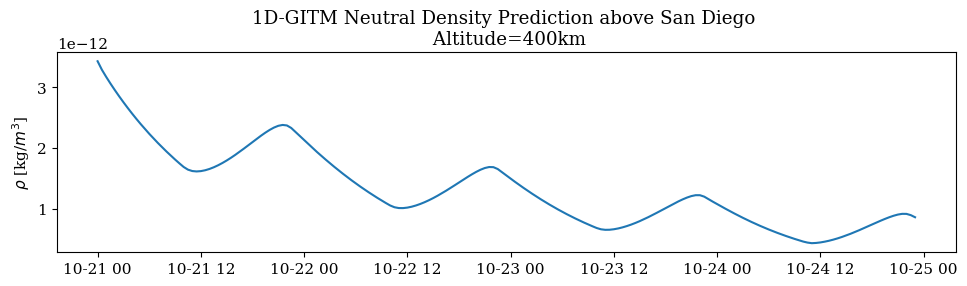

In [28]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(time_stamp_gitm,  np.exp(sol[1, 0, 12, :]).flatten("F")*float(rho0))
ax.set_title("1D-GITM Neutral Density Prediction above San Diego \n Altitude=400km")
ax.set_ylabel(r"$\rho$ [kg/$m^3$]")
#ax.set_yscale("log")
plt.tight_layout()
#plt.savefig("figs/1d_gitm_san_diego_400_altitude.png", dpi=400)